# Analyzing fire department payrolls in California: 2011-2018

This notebook analyzes annual government payroll [data](https://publicpay.ca.gov/Reports/RawExport.aspx) compiled and released annually by the California state controller's office. The data include anonymized salary information for all employees at cities, counties, special districts and state government. 

---

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import cpi
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,.0f}'.format

### Read the fire payroll data

In [2]:
payroll_fire = pd.read_csv('/Users/mhustiles/data/data/controller/output/payroll_fire.csv')
agency_overtime = pd.read_csv('/Users/mhustiles/data/github/notebooks/payroll/output/agency_overtime.csv')

In [3]:
len(payroll_fire)

307964

---

### What about agencies in our area? 

In [4]:
area_counties = ['LOS ANGELES', 'ORANGE', 'KERN', 'VENTURA', 'RIVERSIDE', 'SAN BERNARDINO']

In [5]:
la_agency_overtime = agency_overtime[(agency_overtime['employercounty'] == 'LOS ANGELES') &\
                                         (agency_overtime['type'] != 'SPECIAL DISTRICT')]

la_area_agency_overtime = agency_overtime[(agency_overtime['employercounty'].isin(area_counties)) &\
                                         (agency_overtime['type'] != 'SPECIAL DISTRICT')]

In [6]:
la_agency_grouped = agency_overtime[agency_overtime['employercounty'].isin(area_counties)]\
    .groupby(['year']).agg({'ot_share_wages':'mean'}).reset_index()

In [7]:
la_agency_grouped

,year,ot_share_wages
0,2011,18
1,2012,20
2,2013,22
3,2014,22
4,2015,24
5,2016,24
6,2017,26
7,2018,25


### Just cities

In [8]:
cities_overtime = agency_overtime[(agency_overtime.type == 'CITY')]
cities_overtime.head()

,Unnamed: 0,employerfull,type,employercounty,year,adjusted_overtime,adjusted_wages,adjusted_basewages,overtime,wages,ot_share_wages
0,0,ALAMEDA_CITY,CITY,ALAMEDA,2011,"788,909","13,773,499","12,984,590","706,696","12,338,155",6
1,1,ALAMEDA_CITY,CITY,ALAMEDA,2012,"547,408","12,792,108","12,244,700","500,510","11,696,174",4
2,2,ALAMEDA_CITY,CITY,ALAMEDA,2013,"626,923","13,579,294","12,952,371","581,609","12,597,783",5
3,3,ALAMEDA_CITY,CITY,ALAMEDA,2014,"1,236,750","14,282,029","13,045,279","1,165,970","13,464,660",9
4,4,ALAMEDA_CITY,CITY,ALAMEDA,2015,"2,300,568","15,568,764","13,268,196","2,171,480","14,695,177",15


### Statewide

In [9]:
state = payroll_fire.groupby(['year']).agg({'adjusted_overtime':'sum', \
                                            'adjusted_basewages':'sum', \
                                            'wages':'sum', \
                                            'overtime':'sum',\
                                           }).reset_index()

In [10]:
state.rename(columns={'adjusted_basewages':'BaseWages',
                      'adjusted_overtime': 'Overtime',\
                      'wages': 'naWages',\
                       'overtime': 'naOvertime',\
                     'year': 'Year'}, inplace=True)

### What was the share of overtime to wages each year? 

In [11]:
state['OT_Share_Wages'] = ( state['naOvertime']  / state['naWages'] )*100

In [12]:
state.head(10)

,Year,Overtime,BaseWages,naWages,naOvertime,OT_Share_Wages
0,2011,"823,273,863","3,293,424,651","3,687,695,075","737,480,036",20
1,2012,"934,736,353","3,252,744,118","3,828,727,957","854,655,020",22
2,2013,"1,002,724,813","3,192,956,185","3,892,417,408","930,247,919",24
3,2014,"1,074,832,337","3,125,091,666","3,959,559,904","1,013,319,056",26
4,2015,"1,199,574,436","3,344,795,811","4,289,378,642","1,132,264,469",26
5,2016,"1,247,706,815","3,446,411,657","4,486,618,422","1,192,552,854",27
6,2017,"1,331,053,053","3,496,694,637","4,712,642,475","1,299,317,519",28
7,2018,"1,365,359,790","3,544,963,370","4,910,323,160","1,365,359,790",28


In [13]:
statemelt = pd.melt(state,id_vars=['Year'], value_vars=['Overtime', 'BaseWages'],\
        var_name='Compensation', value_name='Total')

In [14]:
state.to_csv('output/state.csv')

In [15]:
statemelt.to_csv('output/statemelt.csv')

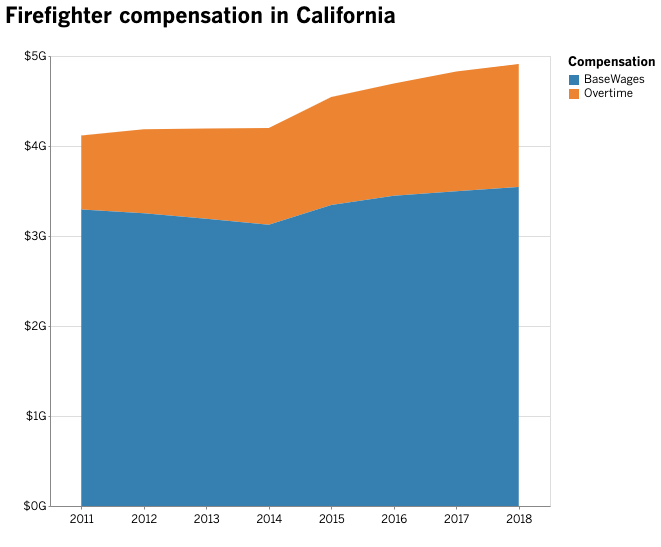

In [16]:
alt.Chart(statemelt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", title=' ', axis=alt.Axis(tickCount=6, format='$~s')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    )
).properties(width=500, title='Firefighter compensation in California')

--- 

### Charting firefighter wages and benefits in Los Angeles

In [17]:
la = payroll_fire[(payroll_fire['employerfull'].str.contains('LOS_ANGELES'))]\
.groupby(['year', 'employerfull']).agg({'adjusted_overtime':'sum', \
                                            'adjusted_basewages':'sum', \
                                        'adjusted_wages':'sum', \
                                            'adjusted_benefits':'sum'\
                                            }).reset_index()

### Clean up the column names

In [18]:
la.rename(columns={'adjusted_overtime': 'Overtime',\
                    'adjusted_basewages': 'BaseWages',\
#                    'adjusted_wages': 'Wages',\
#                    'adjusted_benefits':'Benefits',\
                     'year': 'Year',
                      'employerfull': 'Place'}, inplace=True)

### Melt the dataframe for charting

In [19]:
la_melt = pd.melt(la,id_vars=['Year', 'Place'], value_vars=['Overtime','BaseWages'],\
        var_name='Compensation', value_name='Total')

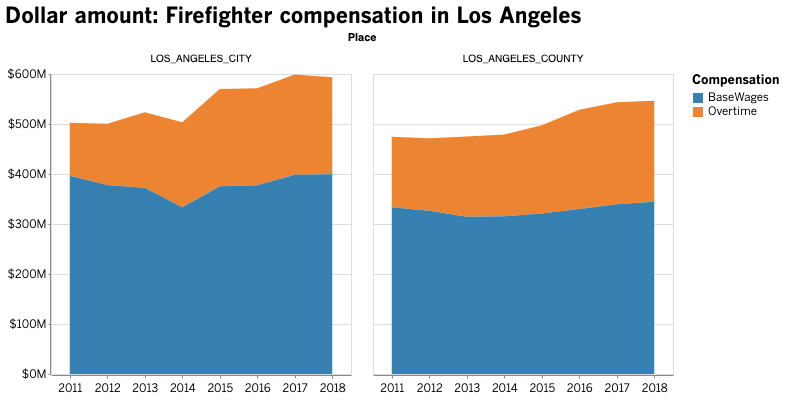

In [20]:
alt.Chart(la_melt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", title=' ', axis=alt.Axis(tickCount=6, format='$,s')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet='Place:N'
).properties(width=300, height=300, columns=2, title='Dollar amount: Firefighter compensation in Los Angeles')

### Normalized version

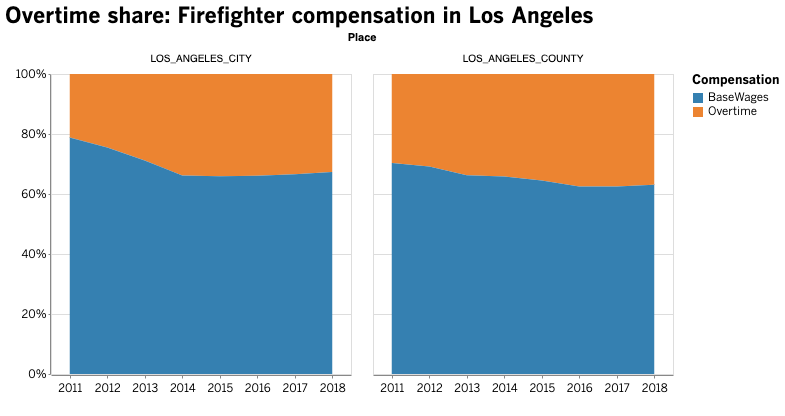

In [21]:
alt.Chart(la_melt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", stack="normalize", title=' ', axis=alt.Axis(tickCount=6, format='%')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet='Place:N'
).properties(width=300, height=300, columns=2, title='Overtime share: Firefighter compensation in Los Angeles')

In [22]:
la_melt.sort_values(by=['Place', 'Compensation']).to_csv('output/la_melt.csv')

---

### Los Angeles-area fire agencies: Share of wages in overtime

In [23]:
la_area = pd.DataFrame(la_agency_overtime[la_agency_overtime['employerfull'] \
                                          != 'LA_HABRA_HEIGHTS_CITY'][['employerfull', 'year', 'ot_share_wages']])

In [24]:
la_agency_grouped['ot_share_wages'] = la_agency_grouped['ot_share_wages']/100

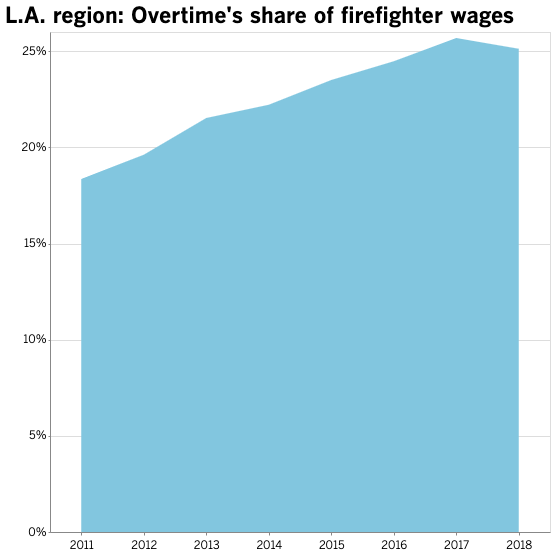

In [25]:
alt.Chart(la_agency_grouped).mark_area().encode(
    x=alt.X('year:N', title='', axis=alt.Axis(format='')),
    y=alt.Y("ot_share_wages:Q",
        scale=alt.Scale(domain=(0, .25)), title="", axis=alt.Axis(format='%', tickCount=6)),
).properties(height=500, width=500, columns=6, title='L.A. region: Overtime\'s share of firefighter wages')

In [26]:
la_area['ot_share_wages'] = la_area['ot_share_wages']/100

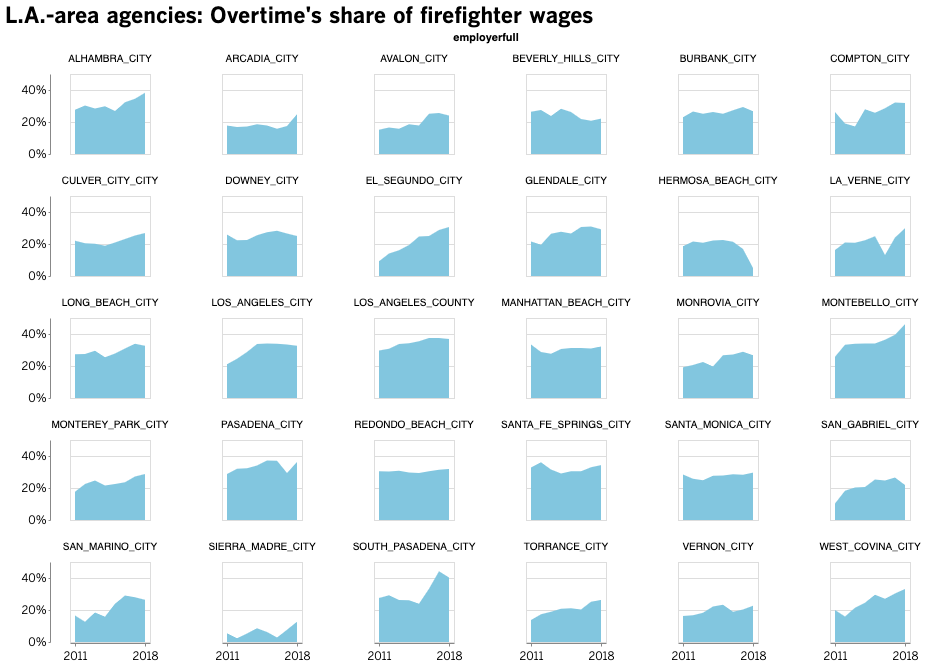

In [27]:
alt.Chart(la_area).mark_area().encode(
    x=alt.X('year:N', title='', axis=alt.Axis(format='', tickCount=2, values=(2011,2018))),
    y=alt.Y("ot_share_wages:Q", title="", axis=alt.Axis(format='%', tickCount=3)),
    facet=alt.Facet('employerfull:N')
).properties(height=80, width=80, columns=6, \
             title='L.A.-area agencies: Overtime\'s share of firefighter wages')

### What's the rate of increase for OT, wages and benefits for each place? 

In [28]:
agency_overtime = pd.read_csv('output/agency_overtime.csv')
agency_overtime.drop(columns=['Unnamed: 0', 'type','wages', 'overtime'], inplace=True)
agency_overtime['employerfull'] = agency_overtime['employerfull'].str.replace('_SPECIAL_DISTRICT','')
agency_overtime['employercounty'] = agency_overtime['employercounty'].str.replace('NAN','')

In [29]:
agency_overtime_2018 = agency_overtime[(agency_overtime['year'] == 2018)]

In [30]:
agency_overtime_2018.sort_values(by='ot_share_wages', ascending=False).head()

,employerfull,employercounty,year,adjusted_overtime,adjusted_wages,adjusted_basewages,ot_share_wages
2307,MONTEZUMA_FIRE_PROTECTION_DISTRICT_(SOLANO),SOLANO,2018,"256,367","313,472","57,105",82
3084,SALIDA_FIRE_PROTECTION_DISTRICT,STANISLAUS,2018,"19,417","26,969","7,552",72
613,CHESTER_PUBLIC_UTILITY_DISTRICT,PLUMAS,2018,"2,209,066","3,446,468","1,237,402",64
3489,SOUTH_LAKE_COUNTY_FIRE_PROTECTION_DISTRICT,LAKE,2018,"66,920","138,091","71,171",48
2259,MONTEBELLO_CITY,LOS ANGELES,2018,"2,947,963","6,384,622","3,436,659",46


In [55]:
agency_overtime.sort_values(by='adjusted_overtime', ascending=False).head(20)

,employerfull,employercounty,year,adjusted_overtime,adjusted_wages,adjusted_basewages,ot_share_wages
1986,LOS_ANGELES_COUNTY,LOS ANGELES,2017,"204,008,622","543,743,624","339,735,002",38
1987,LOS_ANGELES_COUNTY,LOS ANGELES,2018,"201,800,387","546,453,053","344,652,666",37
1978,LOS_ANGELES_CITY,LOS ANGELES,2017,"200,297,491","598,913,979","398,616,488",33
1985,LOS_ANGELES_COUNTY,LOS ANGELES,2016,"198,321,126","528,284,998","329,963,872",38
1976,LOS_ANGELES_CITY,LOS ANGELES,2015,"194,577,723","570,247,170","375,669,446",34
1979,LOS_ANGELES_CITY,LOS ANGELES,2018,"194,037,539","593,514,555","399,477,016",33
1977,LOS_ANGELES_CITY,LOS ANGELES,2016,"193,805,688","571,517,808","377,712,120",34
451,CALFIRE_STATE,,2018,"182,236,906","674,482,853","492,245,948",27
1984,LOS_ANGELES_COUNTY,LOS ANGELES,2015,"176,467,773","497,540,138","321,072,365",35
1975,LOS_ANGELES_CITY,LOS ANGELES,2014,"170,170,047","503,552,469","333,382,422",34


In [32]:
agency_overtime_largest = payroll_fire.groupby('employerfull').agg({'adjusted_overtime':'sum'}).reset_index()

In [33]:
largest = agency_overtime_largest.sort_values(by='adjusted_overtime', ascending=False).head(30)

In [34]:
large_list = largest.employerfull.to_list()

In [35]:
agency_overtime_melt = pd.melt(agency_overtime,id_vars=['year', 'employerfull'], \
                               value_vars=['adjusted_overtime','adjusted_basewages'],\
                                var_name='Compensation', value_name='Amount')

In [36]:
agency_overtime_melt_else = agency_overtime_melt[agency_overtime_melt['employerfull'].isin(large_list)]

In [37]:
large_agency_overtime_melt = agency_overtime_melt[(agency_overtime_melt['Amount'] > 1000000)]

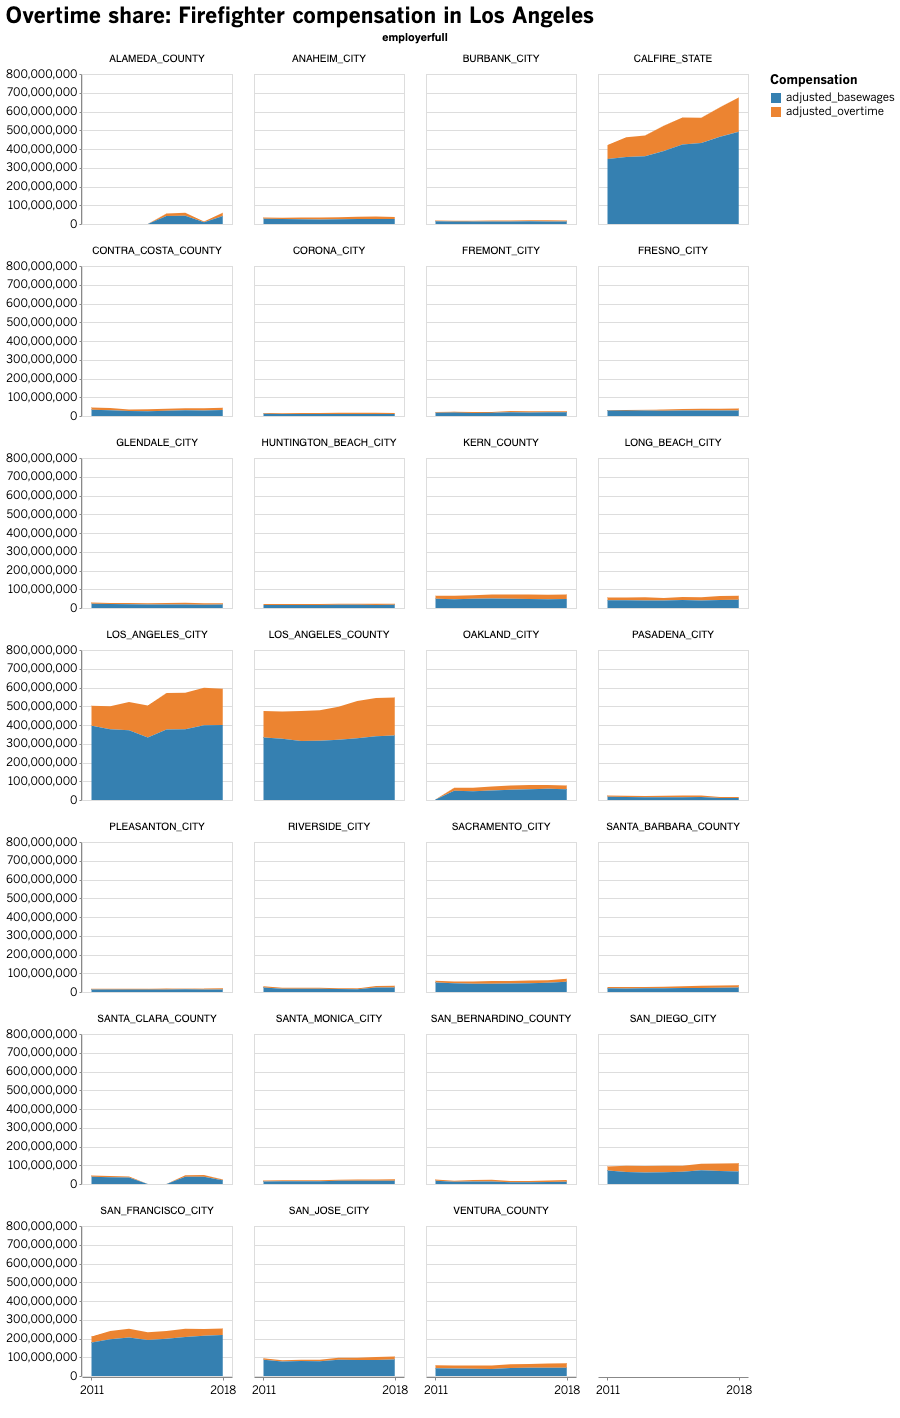

In [38]:
alt.Chart(agency_overtime_melt_else).mark_area().encode(
    x=alt.X("year:N", title=' ', axis=alt.Axis(values=(2011, 2018))),
    y=alt.Y("Amount:Q",
        scale=alt.Scale(domain=(0, 800000000)), title=' ', axis=alt.Axis(tickCount=6, format='')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet='employerfull:N'
).properties(width=150, height=150, columns=4, title='Overtime share: Firefighter compensation in Los Angeles')

---

### How much did overtime, wages increase by agency?

In [39]:
agency_overtime.head()

,employerfull,employercounty,year,adjusted_overtime,adjusted_wages,adjusted_basewages,ot_share_wages
0,ALAMEDA_CITY,ALAMEDA,2011,"788,909","13,773,499","12,984,590",6
1,ALAMEDA_CITY,ALAMEDA,2012,"547,408","12,792,108","12,244,700",4
2,ALAMEDA_CITY,ALAMEDA,2013,"626,923","13,579,294","12,952,371",5
3,ALAMEDA_CITY,ALAMEDA,2014,"1,236,750","14,282,029","13,045,279",9
4,ALAMEDA_CITY,ALAMEDA,2015,"2,300,568","15,568,764","13,268,196",15


In [40]:
agency_ot = pd.pivot_table(agency_overtime, \
                values='adjusted_overtime',\
                index='employerfull', columns=['year']).reset_index()

In [41]:
agency_ot.columns = agency_ot.columns.map(str)

In [42]:
agency_ot_slim = pd.DataFrame(agency_ot[['employerfull','2011','2018']])

In [43]:
agency_ot_slim['ot_change'] = ((agency_ot_slim['2018'] -\
                                agency_ot_slim['2011'])/agency_ot_slim['2011'])*100

In [44]:
agency_basewages = pd.pivot_table(agency_overtime, \
                values='adjusted_basewages',\
                index='employerfull', columns=['year']).reset_index()

In [45]:
agency_basewages.columns = agency_basewages.columns.map(str)

In [46]:
agency_basewages_slim = pd.DataFrame(agency_basewages[['employerfull','2011','2018']])

In [47]:
agency_basewages_slim['ot_change'] = (((agency_basewages_slim['2018'] - \
                                       agency_basewages_slim['2011'])/agency_basewages_slim['2011'])*100).fillna(0)

In [48]:
agency_ot_slim.rename(columns={'2011':'overtime2011',
                      '2018': 'overtime2018',\
                      'ot_change': 'ot_change'}, inplace=True)

In [49]:
agency_basewages_slim.rename(columns={'2011':'wages2011',
                      '2018': 'wages2018',\
                      'ot_change': 'wages_change'}, inplace=True)

In [50]:
agencies = pd.merge(agency_ot_slim, agency_basewages_slim, on='employerfull')

In [51]:
agencies['employer'] = agencies['employerfull'].str.replace('_',' ')

In [52]:
agencies_slim = pd.DataFrame(agencies[['employer','wages_change','ot_change']]).dropna()

### Remove outliers 

In [53]:
agencies_slim = agencies_slim[(agencies_slim['wages_change'] < 1000) &\
                             (agencies_slim['ot_change'] < 1000) ]

In [54]:
agencies_slim.sort_values(by='ot_change', ascending=False)

year,employer,wages_change,ot_change
245,IONE CITY,196,903
559,"VETERANS AFFAIRS, DEPARTMENT OF STATE",-8,874
366,NEWPORT BEACH CITY,204,862
386,OPHIR HILL FIRE PROTECTION DISTRICT,7,851
497,SELMA CITY,-0,825
157,EL CENTRO CITY,74,727
283,LINCOLN CITY,-7,721
73,CALISTOGA CITY,42,685
102,CLOVERDALE FIRE PROTECTION DISTRICT,18,662
346,MORONGO VALLEY COMMUNITY SERVICES DISTRICT,8,658
